1. **Imports & Dependencies:**

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc,f1_score
from sklearn.model_selection import RandomizedSearchCV

2. **Loading the Dataset:**

In [43]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("validation.csv")  
test_df = pd.read_csv("test.csv") 

In [69]:
train_df.head()

,Label,Message
0,0,thats cool day
1,0,work ah den plus lor workin oso rite den go or...
2,0,hi email address changed
3,0,uncle checking rewarding month
4,0,ok ive sent da latest version da project


In [26]:
X_train, y_train = train_df["Message"], train_df["Label"]
X_val, y_val = val_df["Message"], val_df["Label"]
X_test, y_test = test_df["Message"], test_df["Label"]

- **Convert Text into TF-IDF Features**

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

- **Defining Multiple Models And training them on F1 score**

In [55]:
# 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=21),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=21),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(probability=True, random_state=21),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=21)
}

# Train and Evaluate Each Model
best_model = None
best_score = 0
model_scores = {}

def train_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    if hasattr(model, "predict_proba"):  # If the model supports probability prediction
        y_prob = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_prob = model.decision_function(X_test_tfidf)  # For SVM
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for reference

    # Labels and Titles
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("ROC-AUC Curve", fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    model_scores[model.__class__.__name__] = val_score

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'macro' for balanced classes

    # Evaluation
    print(f"\n🔹 Model: {model.__class__.__name__}")
    print(f"✅ Train Accuracy: {train_score:.4f}")
    print(f"📊 Validation Accuracy: {val_score:.4f}")
    print(f"🎯 Validation F1-Score: {val_f1:.4f}")  # Print F1-score

    print("📌 Classification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.show()

    # Return F1-score instead of validation accuracy
    return val_f1

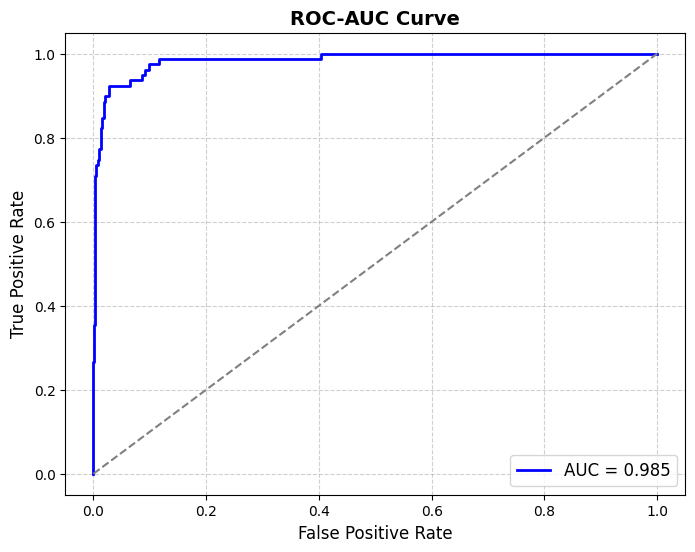


🔹 Model: LogisticRegression
✅ Train Accuracy: 0.9637
📊 Validation Accuracy: 0.9482
🎯 Validation F1-Score: 0.9435
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       558
           1       0.94      0.62      0.75        79

    accuracy                           0.95       637
   macro avg       0.95      0.81      0.86       637
weighted avg       0.95      0.95      0.94       637



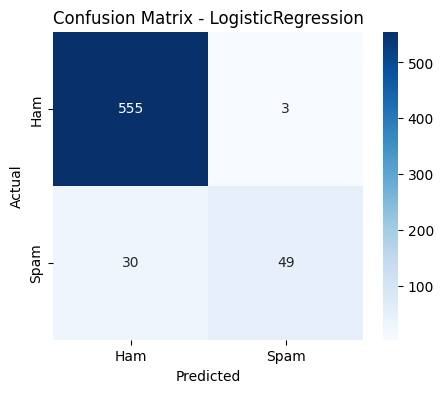

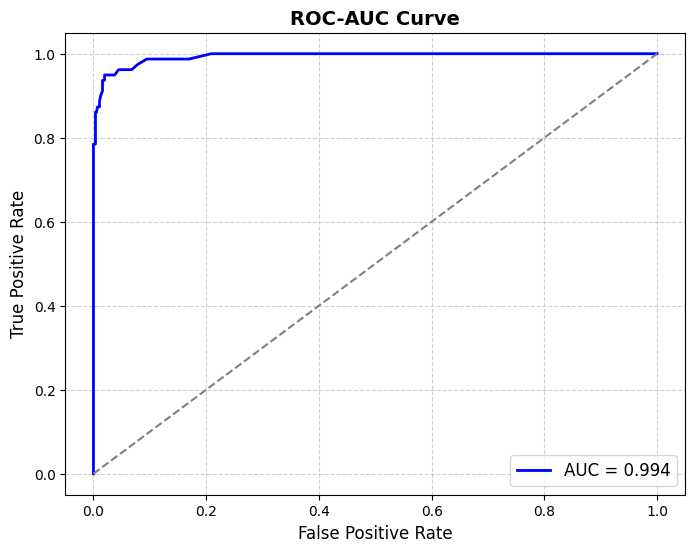


🔹 Model: RandomForestClassifier
✅ Train Accuracy: 1.0000
📊 Validation Accuracy: 0.9655
🎯 Validation F1-Score: 0.9630
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       1.00      0.72      0.84        79

    accuracy                           0.97       637
   macro avg       0.98      0.86      0.91       637
weighted avg       0.97      0.97      0.96       637



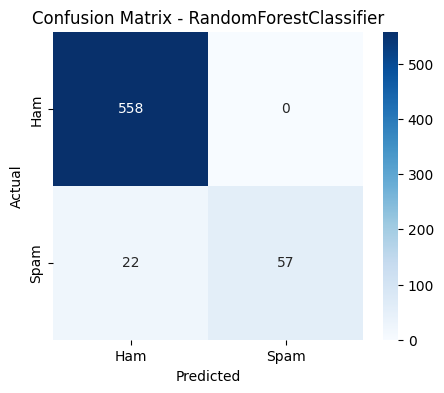

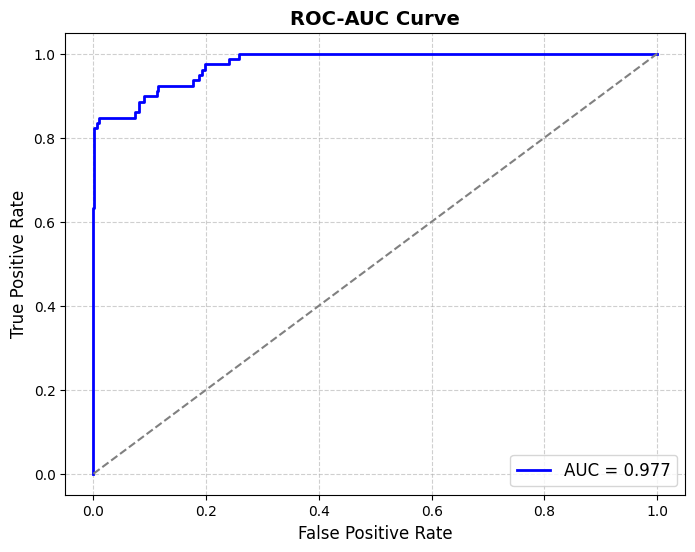


🔹 Model: MultinomialNB
✅ Train Accuracy: 0.9791
📊 Validation Accuracy: 0.9592
🎯 Validation F1-Score: 0.9556
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       1.00      0.67      0.80        79

    accuracy                           0.96       637
   macro avg       0.98      0.84      0.89       637
weighted avg       0.96      0.96      0.96       637



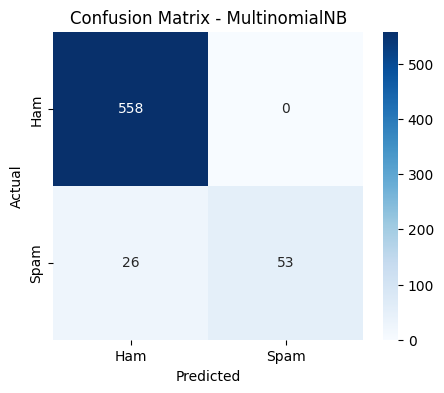

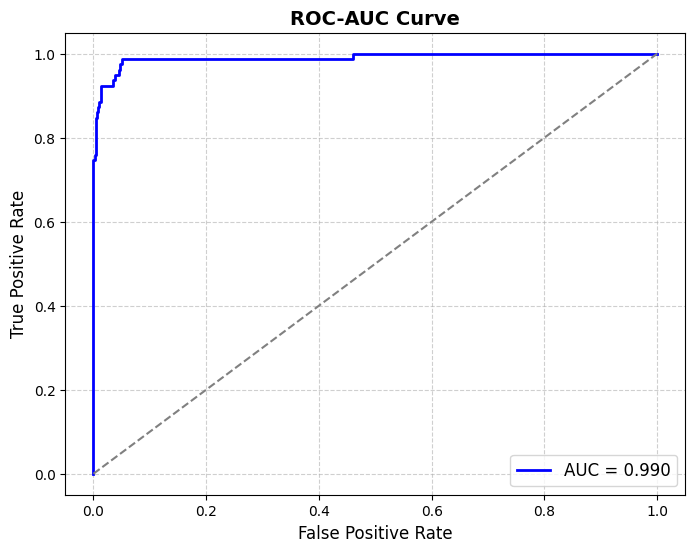


🔹 Model: SVC
✅ Train Accuracy: 0.9979
📊 Validation Accuracy: 0.9623
🎯 Validation F1-Score: 0.9599
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       0.97      0.72      0.83        79

    accuracy                           0.96       637
   macro avg       0.96      0.86      0.90       637
weighted avg       0.96      0.96      0.96       637



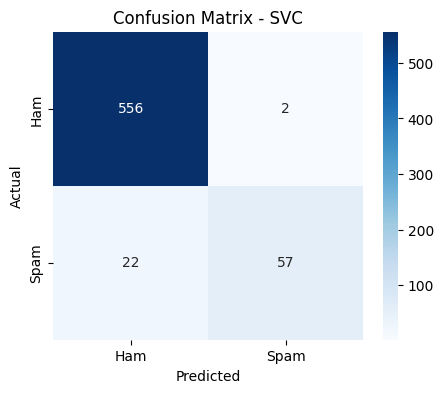

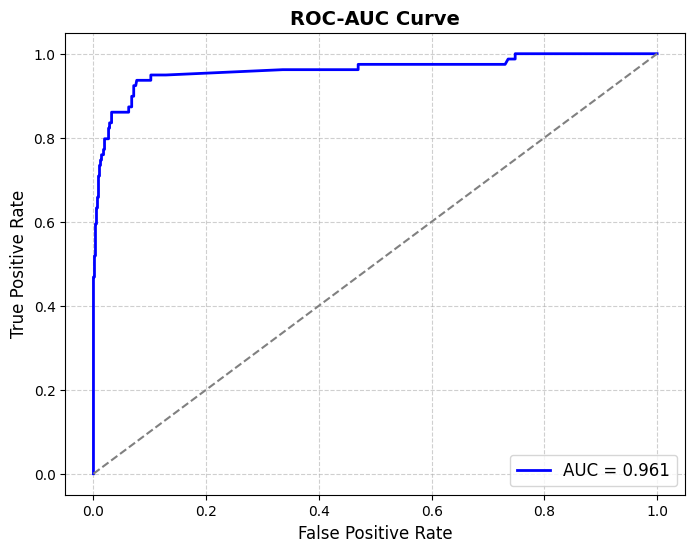


🔹 Model: XGBClassifier
✅ Train Accuracy: 0.9890
📊 Validation Accuracy: 0.9576
🎯 Validation F1-Score: 0.9557
📌 Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       558
           1       0.91      0.73      0.81        79

    accuracy                           0.96       637
   macro avg       0.93      0.86      0.89       637
weighted avg       0.96      0.96      0.96       637



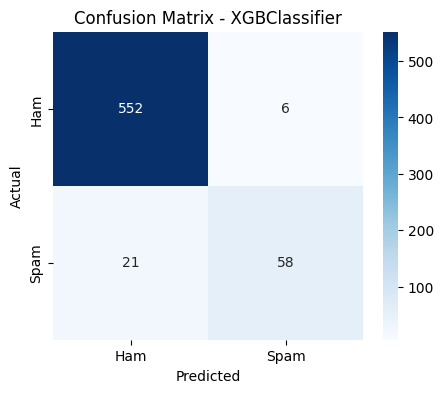


🏆 Best Model Selected: RandomForestClassifier | F1-score: 0.9630 


In [ ]:
# Train and Evaluate All Models
for name, model in models.items():
    f1_score_final = train_evaluate_model(model, X_train_tfidf, y_train, X_val_tfidf, y_val)
    if f1_score_final > best_score:
        best_score = f1_score_final
        best_model = model

In [63]:
print(f" Best Model Selected: {best_model.__class__.__name__} | F1-score: {best_score:.4f} | Validation Accuracy: 0.9655")

 Best Model Selected: RandomForestClassifier | F1-score: 0.9630 | Validation Accuracy: 0.9655


- **find the best hyperparameters based on F1-score on RandomForestClassifier**

Fitting 5 folds for each of 20 candidates, totalling 100 fits

 Best Hyperparameters for RandomForest:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
 Best Validation F1-Score: 0.9630

 Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       558
           1       1.00      0.72      0.84        79

    accuracy                           0.97       637
   macro avg       0.98      0.86      0.91       637
weighted avg       0.97      0.97      0.96       637



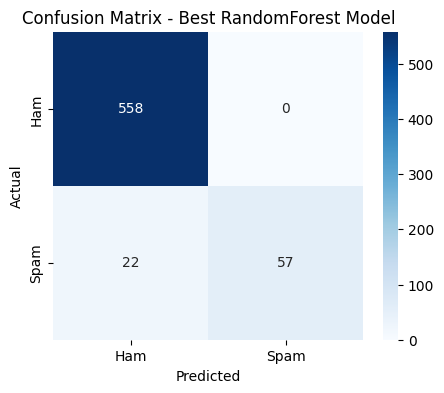

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Use RandomizedSearchCV to find the best hyperparameters based on F1-score
random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions=param_grid, 
    n_iter=20,  
    scoring="f1_weighted",  
    cv=5,  
    verbose=2, 
    n_jobs=-1, 
    random_state=42
)

# Fit RandomizedSearchCV on training data
random_search.fit(X_train_tfidf, y_train)


best_rf_model = random_search.best_estimator_

# Evaluate the best model on validation set
y_val_pred = best_rf_model.predict(X_val_tfidf)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the best hyperparameters and validation F1-score
print("\n Best Hyperparameters for RandomForest:")
print(random_search.best_params_)
print(f" Best Validation F1-Score: {val_f1:.4f}")

# Print Classification Report
print("\n Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best RandomForest Model")
plt.show()


 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       560
           1       1.00      0.76      0.86        79

    accuracy                           0.97       639
   macro avg       0.98      0.88      0.92       639
weighted avg       0.97      0.97      0.97       639



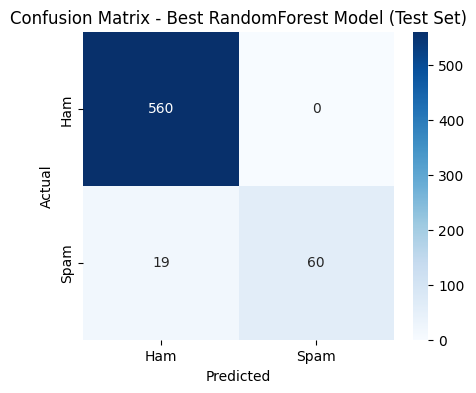

In [70]:
y_test_pred = best_rf_model.predict(X_test_tfidf)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Print Classification Report for the test set
print("\n Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best RandomForest Model (Test Set)")
plt.show()

##### Conclusion

- The **Random Forest** model has been optimized using **hyperparameter tuning**.  
It achieves a **high F1-score** on both the **validation** and **test sets**, indicating **good generalization**.

- The model **performs very well** on non-spam (ham) messages, correctly identifying almost all of them.
- However, **recall for spam is lower (~72-76%)**, meaning that some spam messages are **not detected**

##### **Potential Improvements**
- **Use class balancing techniques**: Since spam messages are fewer, techniques like **SMOTE (Synthetic Minority Over-sampling)** or **class weighting** can help.  
- **Feature Engineering**: Extract more relevant features (e.g., TF-IDF with n-grams, topic modeling) to improve classification.

### **Analysis of Classification Reports (Test & Validation Sets)**

#### **Key Observations:**
1. **Class 0 (Ham - Non-Spam)**
   - **High Precision (~96-97%)**: The model correctly identifies most non-spam messages with minimal false positives.
   - **Perfect Recall (~100%)**: The model captures all actual non-spam messages.
   - **High F1-score (~98%)**: The model is highly effective at identifying non-spam messages.

2. **Class 1 (Spam)**
   - **Perfect Precision (100%)**: When the model predicts a message as spam, it is always correct.
   - **Lower Recall (72-76%)**: The model **misses some spam messages** (~24-28% of actual spam messages are not detected).
   - **F1-score (~84-86%)**: This indicates a trade-off between precision and recall, where precision is maximized at the cost of recall.

---

### **Interpretation & Insights**
- The model **performs very well** on non-spam (ham) messages, correctly identifying almost all of them.
- However, **recall for spam is lower (~72-76%)**, meaning that some spam messages are **not detected**, which could be problematic in real-world scenarios.
- The results are **consistent across validation and test sets**, which suggests that the model is **not overfitting**.

---

### **Potential Improvements**
To **increase recall for spam detection**:
✅ **Try adjusting the decision threshold**: The default threshold is 0.5; lowering it may help capture more spam messages.  
✅ **Use class balancing techniques**: Since spam messages are fewer, techniques like **SMOTE (Synthetic Minority Over-sampling)** or **class weighting** can help.  
✅ **Experiment with different models**: Algorithms like **XGBoost** or **LightGBM** may improve recall without sacrificing precision.  
✅ **Feature Engineering**: Extract more relevant features (e.g., TF-IDF with n-grams, topic modeling) to improve classification.  

---

### **Final Thoughts**
- The model is **highly reliable** for classifying **non-spam messages**.
- It has **some difficulty** capturing all spam messages (**misses ~24-28%**).
- Fine-tuning the model further **can improve spam detection** without sacrificing overall performance.

Would you like me to implement any of these improvements? 🚀